In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("hourly_load.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)


In [3]:
# 2. Split into Federated Clients
#=====================================================================
N_CLIENTS = 5
df["client_id"] = pd.qcut(df.index, q=N_CLIENTS, labels=[f"client_{i+1}" for i in range(N_CLIENTS)])

clients = {cid: df[df["client_id"] == cid].reset_index(drop=True)
           for cid in df["client_id"].unique()}

In [4]:
# 3. Build time-series windows for each client
#=====================================================================
def create_timeseries(data, window=24):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data.reshape(-1, 1))

    X, y = [], []
    for i in range(window, len(scaled)):
        X.append(scaled[i-window:i, 0])
        y.append(scaled[i, 0])

    X = np.array(X).reshape(-1, window, 1)
    y = np.array(y)
    return X, y, scaler

client_X, client_y, client_scalers = {}, {}, {}

for cid, cdf in clients.items():
    X, y, scaler = create_timeseries(cdf["load"].values)
    client_X[cid] = X
    client_y[cid] = y
    client_scalers[cid] = scaler

In [5]:
# 4. Transformer Model
#=====================================================================
def transformer_encoder(inputs, num_heads=4, ff_dim=128):
    x = tf.keras.layers.LayerNormalization()(inputs)
    attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(x, x)
    x = tf.keras.layers.Add()([inputs, attn])

    ff = tf.keras.Sequential([
        tf.keras.layers.Dense(ff_dim, activation="relu"),
        tf.keras.layers.Dense(inputs.shape[-1])
    ])

    x_ff = ff(tf.keras.layers.LayerNormalization()(x))
    return tf.keras.layers.Add()([x, x_ff])


def build_model(window=24):
    inputs = tf.keras.Input(shape=(window, 1))
    x = tf.keras.layers.Dense(32)(inputs)
    x = transformer_encoder(x)
    x = transformer_encoder(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mae")
    return model

In [6]:
# 5. Manual Federated Averaging
#=====================================================================
def federated_avg(weights_list):
    new_weights = []
    for weights in zip(*weights_list):
        new_weights.append(np.mean(np.array(weights), axis=0))
    return new_weights

In [7]:
# 6. Federated Training Loop
#=====================================================================
ROUNDS = 10
global_model = build_model()

for rnd in range(1, ROUNDS + 1):
    client_weights = []

    for cid in clients.keys():
        model = build_model()
        model.set_weights(global_model.get_weights())  # sync with global

        model.fit(
            client_X[cid],
            client_y[cid],
            epochs=1,
            batch_size=32,
            verbose=0
        )

        client_weights.append(model.get_weights())

    # FedAvg aggregation
    new_global_weights = federated_avg(client_weights)
    global_model.set_weights(new_global_weights)

    print(f"Round {rnd}/{ROUNDS} completed.")

Round 1/10 completed.
Round 2/10 completed.
Round 3/10 completed.
Round 4/10 completed.
Round 5/10 completed.
Round 6/10 completed.
Round 7/10 completed.
Round 8/10 completed.
Round 9/10 completed.
Round 10/10 completed.


In [8]:
# 7. Predict Full Dataset
#=====================================================================
df_pred = df.copy()
df_pred["predicted_load"] = np.nan
WINDOW = 24

for cid, cdf in clients.items():
    X, _, scaler = create_timeseries(cdf["load"].values)
    preds = global_model.predict(X)
    preds_inv = scaler.inverse_transform(preds)

    rows = df_pred[df_pred["client_id"] == cid].index
    df_pred.loc[rows[WINDOW:], "predicted_load"] = preds_inv.squeeze()

df_pred.to_csv("federated_predictions.csv", index=False)
print("Saved: federated_predictions.csv")
print(df_pred.head())

378/378 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Saved: federated_predictions.csv
             datetime         load client_id  predicted_load
0 2018-01-01 00:00:00  1742.110000  client_1             NaN
1 2018-01-01 01:00:00  1568.937500  client_1             NaN
2 2018-01-01 02:00:00  1468.707500  client_1             NaN
3 2018-01-01 03:00:00  1424.403333  client_1             NaN
4 2018-01-01 04:00:00  1471.805000  client_1             NaN


In [9]:
import matplotlib.pyplot as plt

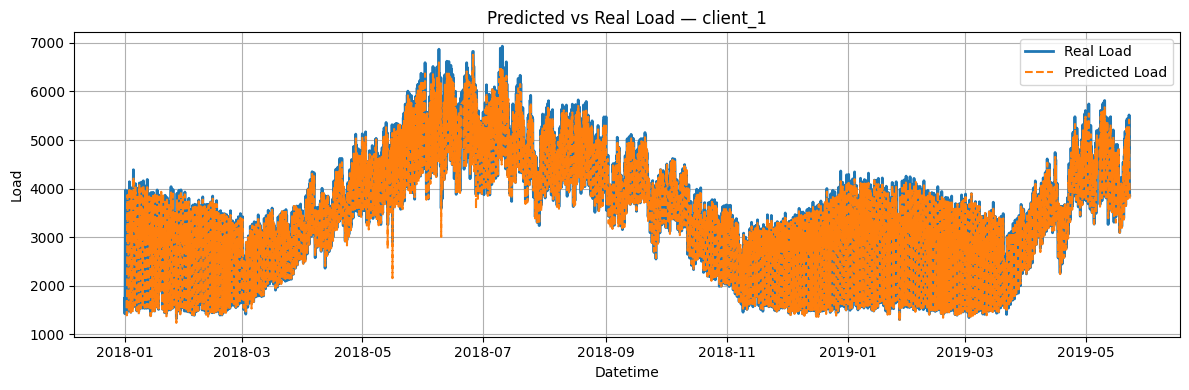

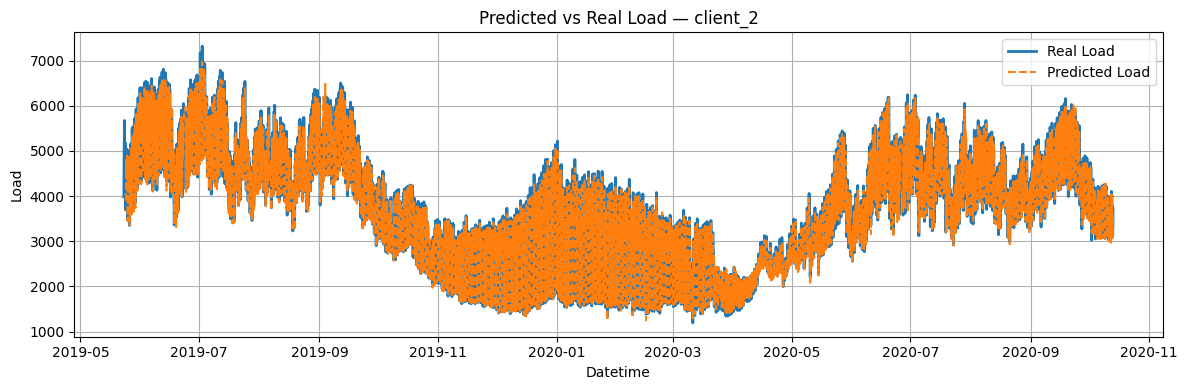

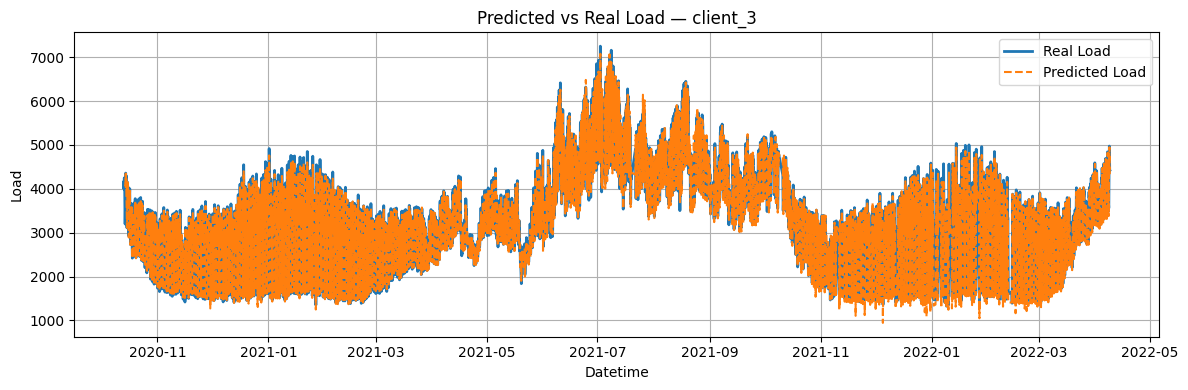

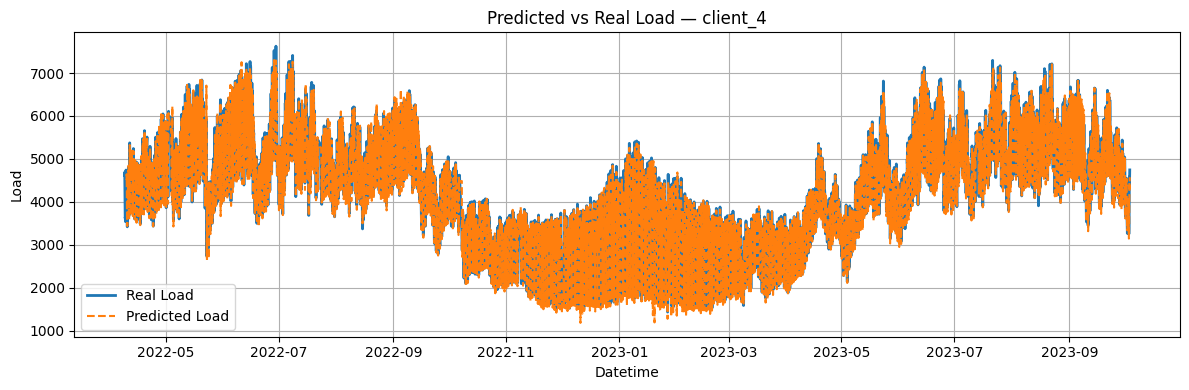

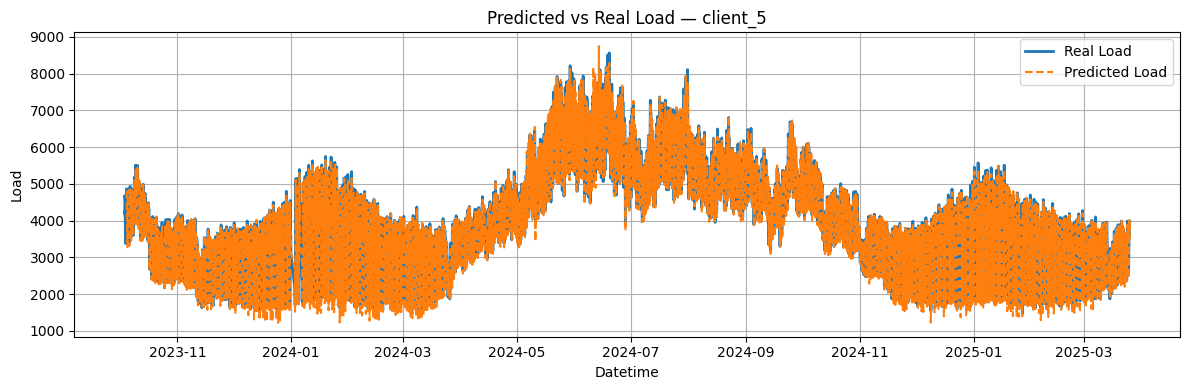

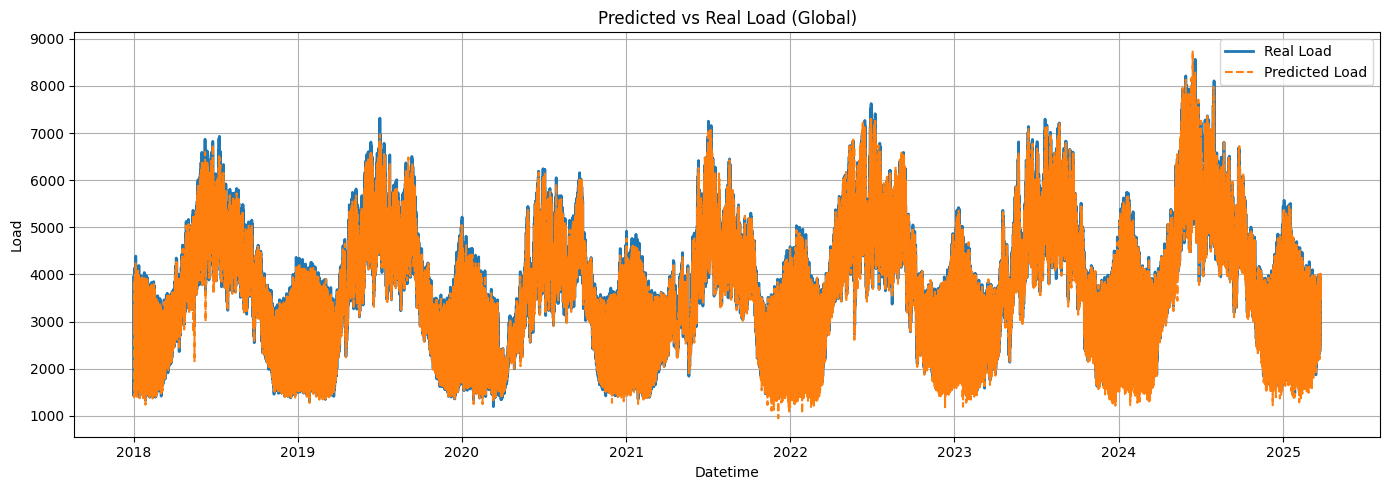

Saved client-wise and global plots.


In [10]:
# 8. Plot Predicted vs Real (Per Client)
#=====================================================================
for cid in clients.keys():
    cdf = df_pred[df_pred["client_id"] == cid]

    plt.figure(figsize=(12, 4))
    plt.plot(cdf["datetime"], cdf["load"], label="Real Load", linewidth=2)
    plt.plot(cdf["datetime"], cdf["predicted_load"], label="Predicted Load", linestyle="--")

    plt.title(f"Predicted vs Real Load — {cid}")
    plt.xlabel("Datetime")
    plt.ylabel("Load")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plot_{cid}.png")
    plt.show()

#=====================================================================
# 9. Combined Plot for Entire Dataset
#=====================================================================
plt.figure(figsize=(14, 5))
plt.plot(df_pred["datetime"], df_pred["load"], label="Real Load", linewidth=2)
plt.plot(df_pred["datetime"], df_pred["predicted_load"], label="Predicted Load", linestyle="--")

plt.title("Predicted vs Real Load (Global)")
plt.xlabel("Datetime")
plt.ylabel("Load")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plot_global.png")
plt.show()

print("Saved client-wise and global plots.")

In [11]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)
import numpy as np

# Drop rows where prediction is NaN (first 24 hours per client)
df_eval = df_pred.dropna(subset=["predicted_load"]).copy()

y_true = df_eval["load"].values
y_pred = df_eval["predicted_load"].values

#=========================================================
# 1️⃣  REGRESSION METRICS (MAIN METRICS)
#=========================================================
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAE  = mean_absolute_error(y_true, y_pred)
MSE  = mean_squared_error(y_true, y_pred)
RMSE = np.sqrt(MSE)
R2   = r2_score(y_true, y_pred)
MAPE = mape(y_true, y_pred)

print("\n================= REGRESSION METRICS =================")
print(f"MAE  : {MAE:.4f}")
print(f"MSE  : {MSE:.4f}")
print(f"RMSE : {RMSE:.4f}")
print(f"R²   : {R2:.4f}")
print(f"MAPE : {MAPE:.2f}%")



================= REGRESSION METRICS =================
MAE  : 89.9646
MSE  : 17601.6956
RMSE : 132.6714
R²   : 0.9886
MAPE : 2.59%


In [12]:
#=========================================================
# SAVE GLOBAL MODEL
#=========================================================
global_model.save("global_transformer_model.h5")
print("Saved: global_transformer_model.h5")


Saved: global_transformer_model.h5


In [13]:
import tensorflow as tf

# Load WITHOUT compiling!
global_model = tf.keras.models.load_model(
    "global_transformer_model.h5",
    compile=False
)

# Recompile manually
global_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.MeanAbsoluteError()
)

print("Model loaded and recompiled successfully.")


Model loaded and recompiled successfully.


In [14]:
import pandas as pd

In [15]:
df = pd.read_csv("federated_predictions.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df_pred = df.sort_values("datetime").reset_index(drop=True)


In [16]:
df_pred.head()

,datetime,load,client_id,predicted_load
0,2018-01-01 00:00:00,1742.110000,client_1,NaN
1,2018-01-01 01:00:00,1568.937500,client_1,NaN
2,2018-01-01 02:00:00,1468.707500,client_1,NaN
3,2018-01-01 03:00:00,1424.403333,client_1,NaN
4,2018-01-01 04:00:00,1471.805000,client_1,NaN
